# Image Parser

We are gonna extract some meaningful information from Images which is available in pdf files.
- Step 1: Convert pdf to image using **pdf2image** library
- Step 2: Preprocess the image (Apply **adaptive thresholding using OpenCV2**)
- Step 3: Extracting text from image by passing it through **tesseract OCR engine**
- Step 4: Finding useful information from text using **RegEx**

In [1]:
# importing necessary libraries
from pdf2image import convert_from_path
import pytesseract
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
from PIL.PpmImagePlugin import PpmImageFile # used as type hint
from typing import Dict # used as type hint
import os
from pdf2image import convert_from_path

# Get the current working directory (where your Jupyter notebook is running)
current_dir = os.getcwd()

# Path of the PDF file in the same directory as the notebook
pdf_path = os.path.join(current_dir, "Resume_VamshiKrishna.pdf")

# Setting Poppler path for macOS
POPPLER_PATH = "/opt/homebrew/bin"

# Convert PDF to image using pdf2image
pages = convert_from_path(pdf_path, poppler_path=POPPLER_PATH)
pages

# Proceed with further processing

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

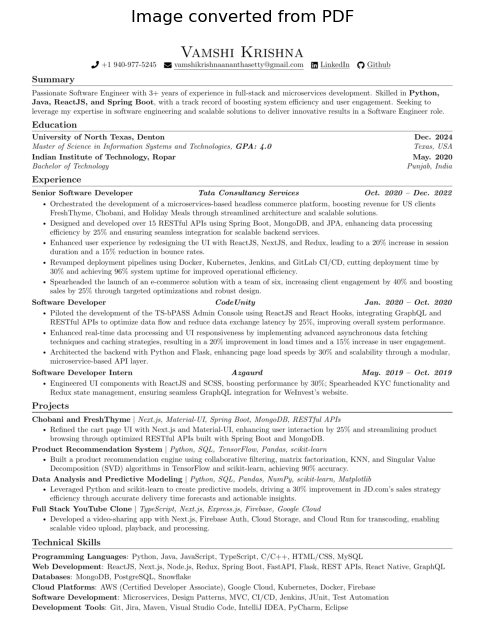

In [2]:
# Lets visualize our image
# pages[0].show() -> this PIL show() function opens image in a new window
plt.figure(figsize=(6,8))
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.show()

In [3]:
import pytesseract

# Set the path for Tesseract
pytesseract.pytesseract.tesseract_cmd = r"/opt/homebrew/bin/tesseract"  # Update this path based on the output from 'which tesseract'

# Extract text from image using pytesseract
text = pytesseract.image_to_string(pages[0], lang="eng")
print(text)

VAMSHI KRISHNA

oJ +1 940-977-5245 §% vamshikrishnaananthasettyQ@gmail.com ff LinkedIn © Github

Summary

Passionate Software Engineer with 3+ years of experience in full-stack and microservices development. Skilled in Python,
Java, ReactJS, and Spring Boot, with a track record of boosting system efficiency and user engagement. Seeking to
leverage my expertise in software engineering and scalable solutions to deliver innovative results in a Software Engineer role.

Education

University of North Texas, Denton Dec. 2024
Master of Science in Information Systems and Technologies, GPA: 4.0 Texas, USA
Indian Institute of Technology, Ropar May. 2020
Bachelor of Technology Punjab, India
Experience

Senior Software Developer Tata Consultancy Services Oct. 2020 — Dec. 2022

¢ Orchestrated the development of a microservices-based headless commerce platform, boosting revenue for US clients
FreshThyme, Chobani, and Holiday Meals through streamlined architecture and scalable solutions.
¢ Designed a

🔎 **Observation:** Pytesseract couldn't extract text under the shadow in our image. Also a long unknown string after address.

💡 **Solution:** Apply image thresholding using OpenCV2 (ref: [cv2 documentation](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html))

Types of thresholding:
1) Simple Thresholding:
> For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value. The function `cv.threshold` is used to apply the thresholding.

2) Adaptive Thresholding:
> In simple thresholding, we use one global value as a threshold. But this might not be good in all cases, e.g. if an image has different lighting conditions in different areas. In that case, adaptive thresholding can help. Here, the algorithm determines the threshold for a pixel based on a small region around it. So we get different thresholds for different regions of the same image which gives better results for images with varying illumination.

**We will use adaptive thresholding**

In [4]:
# A function to preprocess our image
def preprocess_image(img: PpmImageFile) -> np.ndarray:
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY) # Color image -> Grayscale image
    resized = cv2.resize(gray, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR) # Up-sizing for better extraction results
    processed_image = cv2.adaptiveThreshold(
        resized, # our resized image
        255, # max pixel value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # adaptive thresholding
        # cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, # converting to binary (only black/white)
        63, # block size (after trial and error)
        12  # constant (after trial and error)
    )
    return processed_image

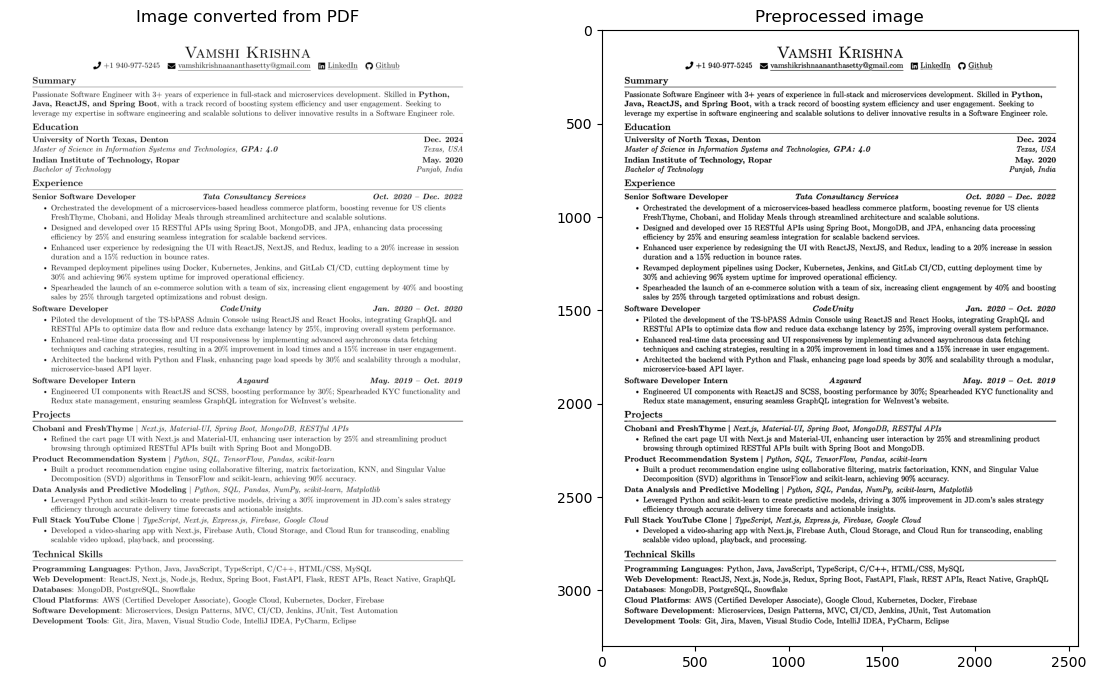

In [5]:
# Applying preprocessing on image
img = preprocess_image(pages[0])

# Visualize our images before and after preprocessing
plt.figure(figsize=(14,8))
plt.subplot(1, 2, 1)
plt.imshow(pages[0])
plt.axis(False)
plt.title("Image converted from PDF")
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray")
plt.axis()
plt.title("Preprocessed image")
plt.show()

In [6]:
# Extract text from preprocessed image
text_1 = pytesseract.image_to_string(img, lang="eng")
print(text_1)

VAMSHI KRISHNA

oJ +1 940-977-5245 §% vamshikrishnaananthasetty@gmail.com ff§ LinkedIn €) Github

Summary

Passionate Software Engineer with 3+ years of experience in full-stack and microservices development. Skilled in Python,
Java, ReactJS, and Spring Boot, with a track record of boosting system efficiency and user engagement. Seeking to
leverage my expertise in software engineering and scalable solutions to deliver innovative results in a Software Engineer role.

Education

University of North Texas, Denton Dec. 2024
Master of Science in Information Systems and Technologies, GPA: 4.0 Texas, USA
Indian Institute of Technology, Ropar May. 2020
Bachelor of Technology Punjab, India
Experience

Senior Software Developer Tata Consultancy Services Oct. 2020 — Dec. 2022

e Orchestrated the development of a microservices-based headless commerce platform, boosting revenue for US clients
FreshThyme, Chobani, and Holiday Meals through streamlined architecture and scalable solutions.

Designed a

In [10]:
def split_into_sections(text: str) -> Dict[str, str]:
    # Define common headers found in resumes
    headers = [
        "Summary", "Education", "Experience", 
        "Projects", "Technical Skills", "Certifications", "Contact"
    ]
    sections = {}
    current_section = "Introduction"
    sections[current_section] = []

    # Split text into lines and categorize into sections
    for line in text.split("\n"):
        line = line.strip()
        if not line:
            continue  # Skip empty lines
        # Check if the line matches a header
        if any(header in line for header in headers):
            current_section = line
            sections[current_section] = []  # Start a new section
        else:
            # Add line to the current section
            sections[current_section].append(line)

    # Combine section contents into single strings
    for key in sections.keys():
        sections[key] = "\n".join(sections[key]).strip()

    return sections

# Splitting the extracted text into structured sections
sections = split_into_sections(all_text)

# Displaying extracted sections
for section, content in sections.items():
    print(f"\n=== {section} ===\n{content}\n")



=== Introduction ===
VAMSHI KRISHNA
oJ +1 940-977-5245 §% vamshikrishnaananthasetty@gmail.com ff§ LinkedIn €) Github


=== Summary ===
Passionate Software Engineer with 3+ years of experience in full-stack and microservices development. Skilled in Python,
Java, ReactJS, and Spring Boot, with a track record of boosting system efficiency and user engagement. Seeking to
leverage my expertise in software engineering and scalable solutions to deliver innovative results in a Software Engineer role.


=== Education ===
University of North Texas, Denton Dec. 2024
Master of Science in Information Systems and Technologies, GPA: 4.0 Texas, USA
Indian Institute of Technology, Ropar May. 2020
Bachelor of Technology Punjab, India


=== Experience ===
Senior Software Developer Tata Consultancy Services Oct. 2020 — Dec. 2022
e Orchestrated the development of a microservices-based headless commerce platform, boosting revenue for US clients
FreshThyme, Chobani, and Holiday Meals through streamlined arc

In [13]:
def refine_parsed_resume(sections: Dict[str, str]) -> Dict[str, str]:
    
    def format_experience(content: str) -> str:
        # Split content into lines
        lines = content.split("\n")
        refined_content = []

        # Track the previous job to group each job with its respective bullet points
        current_job = ""

        for line in lines:
            line = line.strip()

            if line:
                # Check if the line contains a job title or company name
                if "—" in line:
                    # This is a job title and company, start a new section
                    if current_job:  # Append the last job to the content
                        refined_content.append("")  # Add a space between jobs
                    current_job = line
                    refined_content.append(f"- {current_job}")  # Add the job title and company
                else:
                    # Otherwise, this is a responsibility/achievement under the job
                    refined_content.append(f"  - {line}")  # Indented bullet for job responsibilities

        return "\n".join(refined_content)

    def format_projects(content: str) -> str:
        # Split content into lines
        lines = content.split("\n")
        refined_content = []
        for line in lines:
            if line.strip():
                # Project name and tools are separated
                if "|" in line:
                    refined_content.append(f"- {line.strip()}")
                else:
                    refined_content.append(f"  - {line.strip()}")
        return "\n".join(refined_content)

    def format_technical_skills(content: str) -> str:
        # Separate skills into a list
        skills = content.split("\n")
        refined_skills = []
        for skill in skills:
            if skill.strip():
                refined_skills.append(f"  - {skill.strip()}")
        return "\n".join(refined_skills)

    refined_sections = {}
    for section, content in sections.items():
        if section == "Experience":
            refined_sections[section] = format_experience(content)
        elif section == "Projects":
            refined_sections[section] = format_projects(content)
        elif section == "Technical Skills":
            refined_sections[section] = format_technical_skills(content)
        else:
            refined_sections[section] = content.strip()

    return refined_sections


# Refine the extracted sections
refined_resume = refine_parsed_resume(sections)

# Print the refined resume section by section
for section, content in refined_resume.items():
    print(f"\n=== {section} ===\n{content}\n")



=== Introduction ===
VAMSHI KRISHNA
oJ +1 940-977-5245 §% vamshikrishnaananthasetty@gmail.com ff§ LinkedIn €) Github


=== Summary ===
Passionate Software Engineer with 3+ years of experience in full-stack and microservices development. Skilled in Python,
Java, ReactJS, and Spring Boot, with a track record of boosting system efficiency and user engagement. Seeking to
leverage my expertise in software engineering and scalable solutions to deliver innovative results in a Software Engineer role.


=== Education ===
University of North Texas, Denton Dec. 2024
Master of Science in Information Systems and Technologies, GPA: 4.0 Texas, USA
Indian Institute of Technology, Ropar May. 2020
Bachelor of Technology Punjab, India


=== Experience ===
- Senior Software Developer Tata Consultancy Services Oct. 2020 — Dec. 2022
  - e Orchestrated the development of a microservices-based headless commerce platform, boosting revenue for US clients
  - FreshThyme, Chobani, and Holiday Meals through strea